In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pickle
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add 

2025-04-27 12:01:10.800386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745755270.825833  130102 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745755270.833261  130102 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
Base_DIR = '/kaggle/input/flickr-dataset'
working_dir = '/kaggle/working'

## Extract Image Features

In [4]:
# load vgg16
model = VGG16()
# restructure the model and leave the fully connected layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

I0000 00:00:1745755290.721525  130102 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745755290.722244  130102 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
# extract features from image
features = {}
directory = os.path.join(Base_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image id
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature
    

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1745755295.936780  130174 service.cc:148] XLA service 0x7c6e44004110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745755295.936819  130174 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745755295.936826  130174 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745755296.020823  130174 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745755297.982138  130174 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
# store features in pickle
pickle.dump(features,open(os.path.join(working_dir,'features.pkl'),'wb'))

In [7]:
# load featues from pickle
with open(os.path.join(working_dir,'features.pkl'),'rb')as f:
    features = pickle.load(f)

## Load the Caption Data

In [8]:
with open(os.path.join(Base_DIR,'captions.txt'),'r')as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to caption
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)
    

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

In [11]:
import re
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocess steps
            caption = caption.lower()
            caption = re.sub(r'[^a-z]', ' ', caption)
            caption = re.sub('\s+', ' ', caption)
            caption = 'start '+" ".join([word for word in caption.split() if len(word)>1])+' end'
            captions[i] = caption

In [12]:
  # before preprocess of data
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# preprocess the text
clean(mapping)

In [14]:
  # after preprocess of data
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [15]:
# store features in pickle
pickle.dump(mapping,open(os.path.join(working_dir,'mapping.pkl'),'wb'))

In [16]:
all_caption = []
for key in mapping:
    for caption in mapping[key]:
        all_caption.append(caption)

In [17]:
len(all_caption)

40455

In [18]:
all_caption[:10]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end']

In [19]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_caption)
vacab_size = len(tokenizer.word_index) + 1

In [20]:
# store tokenizer in pickle
pickle.dump(tokenizer,open(os.path.join(working_dir,'tokenizer.pkl'),'wb'))

In [21]:
vacab_size

8425

In [22]:
# get max len of the caption available
max_length = max(len(caption.split()) for caption in all_caption)
max_length

35

In [23]:
# Train test split
from sklearn.model_selection import train_test_split
image_ids = list(mapping.keys())
train, test = train_test_split(image_ids,test_size=0.1, random_state=42)

In [24]:
import numpy as np
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq],maxlen=max_length,padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequence
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

                if n == batch_size:
                    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                    yield (X1, X2), y
                    X1, X2, y = list(), list(), list()
                    n = 0
                    


## Model Creation

[Inputs = Image feature (X1) ]
        +
[Processing = Caption sequence (X2)]
       =
[Output = Predict next word]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 35)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 4096)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 256)        │      2,156,800 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 4096)           │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 35, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 35)             │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      1,048,832 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8425)           │      2,165,225 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,961,961 (22.74 MB)

 Trainable params: 5,961,961 (22.74 MB)

 Non-trainable params: 0 (0.00 B)

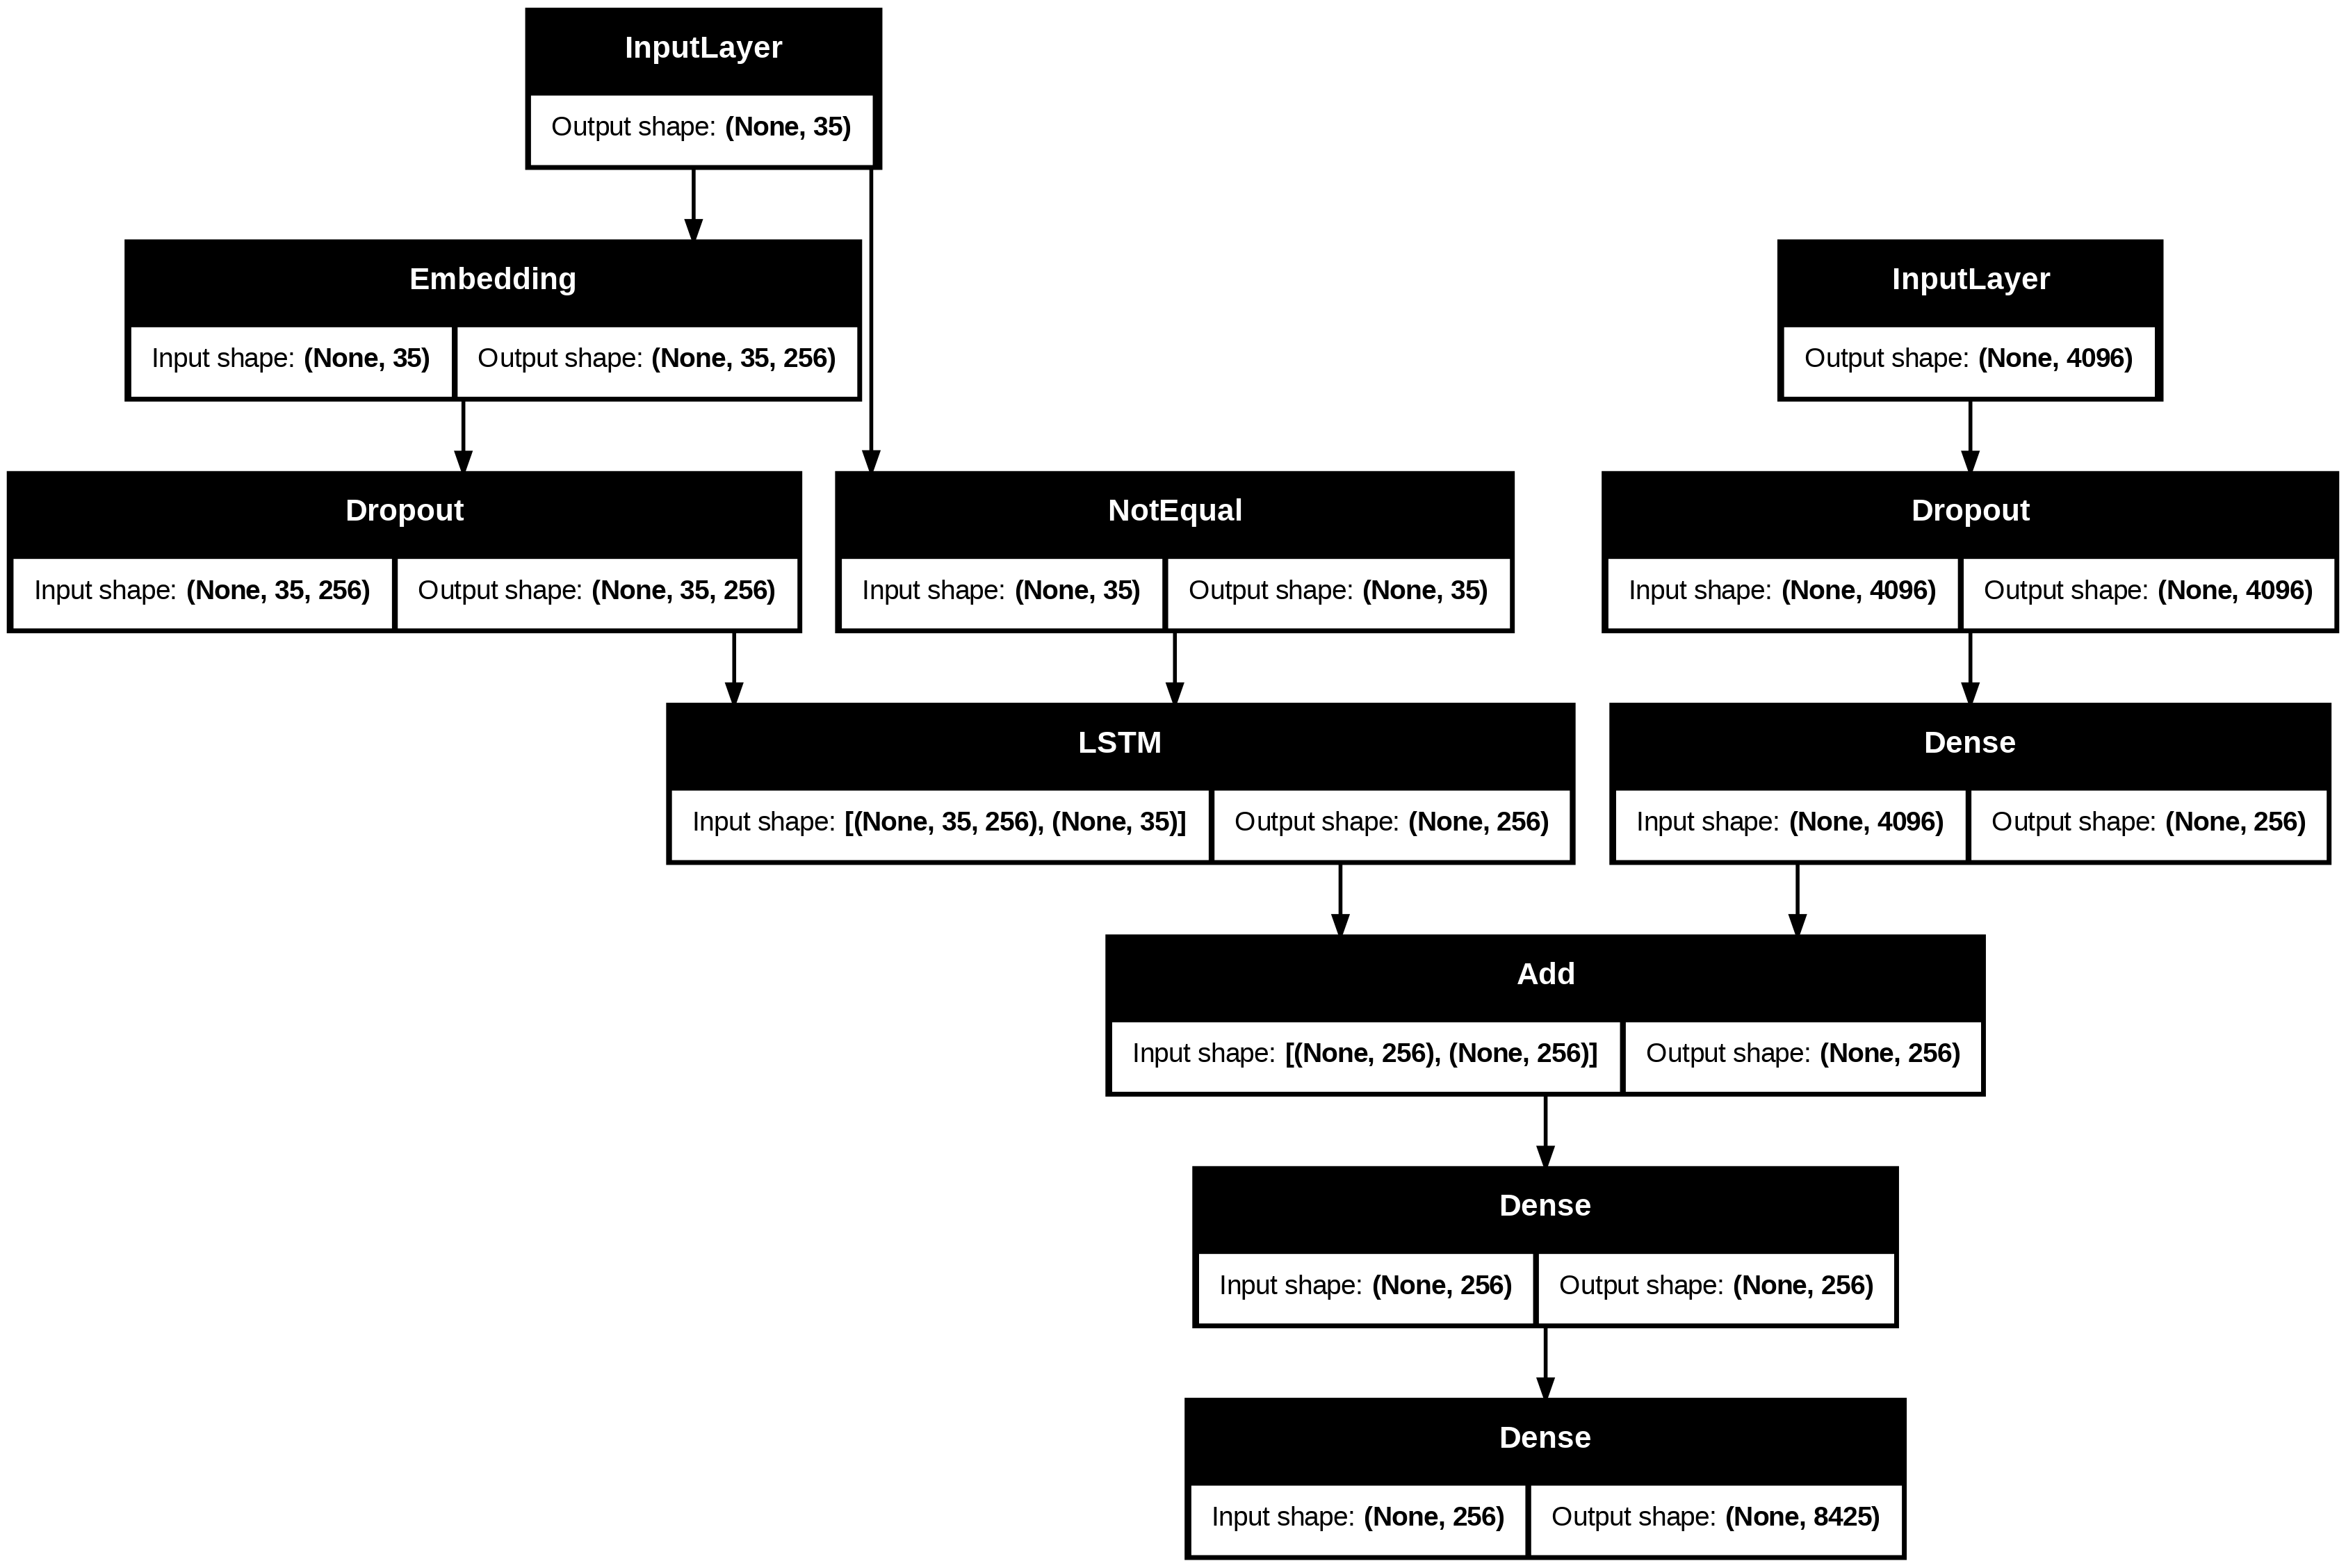

In [25]:
# 1. IMAGE FEATURE EXTRACTOR (X1)
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# 2. SEQUENCE MODEL for CAPTION (X2)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vacab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# 3. DECODER (combine both)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vacab_size, activation='softmax')(decoder2)

# 4. Final model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# 5. Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# 6. Summary
model.summary()

# 7. Plot the model
plot_model(model, show_shapes=True)

In [28]:
# train the model
import tensorflow as tf
import gc
with tf.device('/GPU:0'):
    epochs = 50
    batch_size = 64
    steps = len(train) // batch_size
    
    for i in range(epochs):
        # create data generator
        generator = data_generator(train,mapping, features, tokenizer, max_length, vacab_size, batch_size)
        # fit for one epochs
        model.fit(x = generator, epochs=1, steps_per_epoch=steps, verbose=2)
        tf.keras.backend.clear_session()
        gc.collect()

113/113 - 59s - 524ms/step - loss: 5.4956
113/113 - 55s - 483ms/step - loss: 4.1860
113/113 - 54s - 481ms/step - loss: 3.6741
113/113 - 54s - 480ms/step - loss: 3.3850
113/113 - 54s - 478ms/step - loss: 3.1812
113/113 - 54s - 480ms/step - loss: 3.0270
113/113 - 53s - 470ms/step - loss: 2.9084
113/113 - 53s - 471ms/step - loss: 2.8161
113/113 - 55s - 486ms/step - loss: 2.7370
113/113 - 55s - 484ms/step - loss: 2.6629
113/113 - 54s - 481ms/step - loss: 2.6002
113/113 - 54s - 474ms/step - loss: 2.5395
113/113 - 54s - 480ms/step - loss: 2.4866
113/113 - 52s - 457ms/step - loss: 2.4446
113/113 - 55s - 486ms/step - loss: 2.4030
113/113 - 55s - 486ms/step - loss: 2.3648
113/113 - 54s - 478ms/step - loss: 2.3293
113/113 - 55s - 485ms/step - loss: 2.2931
113/113 - 54s - 479ms/step - loss: 2.2593
113/113 - 54s - 480ms/step - loss: 2.2293
113/113 - 54s - 480ms/step - loss: 2.1984
113/113 - 55s - 484ms/step - loss: 2.1733
113/113 - 54s - 478ms/step - loss: 2.1464
113/113 - 54s - 478ms/step - loss:

In [40]:
# save the model
model.save(working_dir + '/model.h5')

## Generate captions for the Image

In [30]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start'
    # iterate over the max length of sequences
    for i in range(max_length):
        # sequence input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence],max_length, padding = 'post')
        # predict next word
        yhat = model.predict([image, sequence],verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'end':
            break
    return in_text
        

In [32]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculate BLUE score
print("BLUE-1: %f" %corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLUE-2: %f" %corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLUE-1: 0.524646
BLUE-2: 0.307878


## Visualize the Results

In [38]:
from PIL import Image 
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Base_DIR,"Images", image_name)
    img = Image.open(img_path)
    captions = mapping[image_id]
    print('----------------Actual-----------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('-----------------Predicted---------------')
    print(y_pred)
    plt.imshow(img)
    

----------------Actual-----------------
start little girl covered in paint sits in front of painted rainbow with her hands in bowl end
start little girl is sitting in front of large painted rainbow end
start small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it end
start there is girl with pigtails sitting in front of rainbow painting end
start young girl with pigtails painting outside in the grass end
-----------------Predicted---------------
start little girl painting hole in the grass from her head end


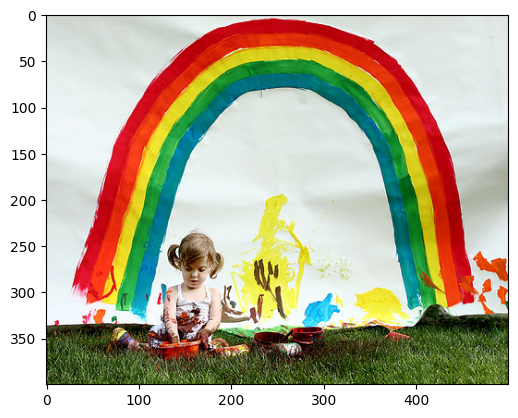

In [39]:
generate_caption('1002674143_1b742ab4b8.jpg')